# Bonus Track Assignment: Solving the Sunspot task
The Sunspot task consists in a next-step prediction (autoregressive, a particular case of transduction) on a time-series consisting in monthly averaged solar sunspots. The dataset can be found in .csv format the following link: https://drive.google.com/file/d/1GK5fqzuAGoo466PIxhnwxtSP0r3uDFWa/view?usp=sharing The dataset can also be imported from MATLAB, using the command load solar_dataset. In this latter case, you will need to convert the data format from cell to mat using the command cell2mat. Split the data into input and target signals. As this is an autoregressive task you will need to refer to the same time-series. For example, in MATLAB, if the solar data is in the variable whole_dataset, you can set input_dataset = whole_dataset(:,1:end-1), and target_dataset = whole_dataset(:,2:end).
Properly separate input and target data, then split the available data in
1) training (first 2398 time steps), and
2) test set (the subsequent 500 timestamps).

For model selection, you will use the data in the training set, with a further split in training and validation. Try to plot the time series data using the command plot.
 Solve this regression task with an LSM, where:
1) The liquid is given by a layer of interconnected Izhikevich neurons, where the input is added as external applied current
2) The readout is a single neuron, trained by pseudo-inversion. Suppose that the liquid states for the training samples are stored in the variables trainStates, and the corresponding target output values are in the variable trainTargets; then the readout weight matrix can be computed in one go as: Wout = trainTargets * pinv(trainStates)
3) Now it is possible to compute the output of the LSM as, for example, trainOutput = Wout * trainStates and analogously for the test time-steps.

Use a hold-out model selection scheme to choose a suitable number of excitable and inhibitory neurons in the liquid (and other hyper-parameters such as the scaling of the input and recurrent connections).

## Libraries

In [1]:
import itertools, copy, sys, json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from numpy import ndarray, concatenate

from LAB1.BonusAssgnment1.LSM import LiquidStateMachine

In [16]:
def salve_plot(model:LiquidStateMachine, x:ndarray, y:ndarray, file_name:str):
    plt.figure(figsize=(30,8))
    plt.plot(model(x),label = "Predicted TR")
    plt.plot(y,label = "Original TR")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.title("Time series on "+file_name)
    plt.grid()
    plt.legend()
    plt.savefig(f"{file_name}.png", bbox_inches='tight')
    plt.show()

## Retrieve the dataset and apply the splitting

In [3]:
# Load and plot the dataset 
input_source = pd.read_csv("./../../Sources/solar_data.csv", header=None).to_numpy().squeeze() #(2899,)

### Hold out (splitting in train, dev & test)

In [4]:
# Splitting in train and test
train, test = input_source[:2398], input_source[2398:]

# Splitting the train in train and dev
train_len = int(train.size * 0.8)
train, dev = train[:train_len], train[train_len:] 

# Build input and target
train_X, train_Y, dev_X, dev_Y, test_X, test_Y = train[:-1], train[1:] , dev[:-1],   dev[1:] , test[:-1],  test[1:]

In [5]:
train_X.shape, train_Y.shape, dev_X.shape, dev_Y.shape, test_X.shape, test_Y.shape

((1917,), (1917,), (479,), (479,), (500,), (500,))

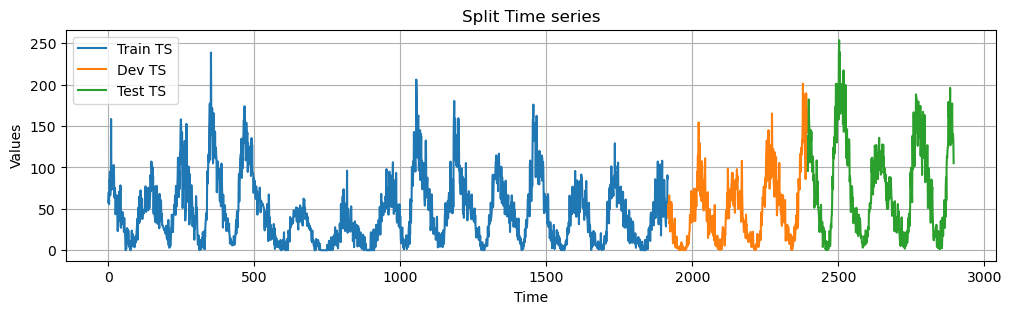

In [6]:
plt.figure(figsize=(12,3))
plt.plot([*range(0,1917)],train_X, label="Train TS")
plt.plot([*range(1917,2396)],dev_X, label="Dev TS")
plt.plot([*range(2396,2896)],test_X, label="Test TS")
plt.title("Split Time series")
plt.xlabel("Time")
plt.ylabel("Values")
plt.grid()
plt.legend()
plt.show()

## Metrics and Grid Search

In [7]:
def MAE(pred:ndarray, target:ndarray) -> float:
  return round(np.abs(pred - target).mean(), 3)

In [8]:
class GridSearch:

    def __init__(self,parameters_grid:dict, tr:tuple, dev:tuple):
        """
          In the grid search, we explore all configurations provided and try to find the best
          hyperparameter configuration using the training set to train the model and the validation
          set to compare the performance among all models instantiated by configurations.
        """
        all_configs = [dict(zip(parameters_grid.keys(), config)) for config in itertools.product(*parameters_grid.values())]

        print("Number of configurations to try: ",len(all_configs))
        """
            Returns the performance in each configuration:

            rank = a list of results for each configuration
            best = best model used to final retrain
            loss = training loss history of the best model
        """
        rank, best = self.run(tr, dev, all_configs)

        # we sort by validation loss
        rank = sorted(rank, key=lambda conf: conf[2])

        print("\nThe best solution in ", rank[0])
        self.best_config = rank[0][0]
        self.best_model = best # the best model discovered

    @staticmethod
    def run(tr:tuple, dev:tuple, configs:list):
        """
        In the grid search, we explore all configurations provided and try to find the best
        hyperparameter configuration using the training set to train the model and the validation
        set to compare the performance among all models instantiated by configurations.
        """
        rank = [] # keep in track the configuration and the corresponding performance
        # we save the best trained model and the training loss history during the epochs

        best = None
        best_dev_loss = sys.maxsize
        for config in tqdm(configs):

            trainer = LiquidStateMachine(units = config["units"],
                                     w_in_e = config["w_in_e"],
                                     w_in_i = config["w_in_i"],
                                     w_rec_e = config["w_rec_e"],
                                     w_rec_i = config["w_rec_i"])

            trainer.fit(train_X, train_Y)

            tr_error = MAE(trainer(tr[0]), tr[1])
            vl_loss = MAE(trainer(dev[0]), dev[1])

            rank.append((config, tr_error, vl_loss))

            # we keep the best model
            if best_dev_loss > vl_loss:
                best_dev_loss = vl_loss
                best = copy.deepcopy(trainer)

        return rank, best

In [9]:
ranges_to_explore = {
    "units" : [100, 300, 500],
    "w_in_e" : [3, 5, 6],
    "w_in_i" : [1, 2, 3],
    "w_rec_e": [0.3 ,0.5, 0.6],
    "w_rec_i": [0.7, 1, 1.1]
}

gs = GridSearch(ranges_to_explore, (train_X, train_Y), (dev_X, dev_Y))
best_config = gs.best_config
best_model = gs.best_model

Number of configurations to try:  243


100%|██████████| 243/243 [05:13<00:00,  1.29s/it]


The best solution in  ({'units': 100, 'w_in_e': 5, 'w_in_i': 3, 'w_rec_e': 0.6, 'w_rec_i': 1.1}, 18.874, 20.118)


### Train, Validation and Test errors in the best configuration

In [10]:
tr_loss = MAE(best_model(train_X) ,train_Y)
print("Train Error", round(tr_loss, 6))

dev_loss = MAE(best_model(dev_X) ,dev_Y)
print("Validation Error", round(dev_loss, 6))

ts_loss = MAE(best_model(test_X) ,test_Y)
print("Test Error", round(ts_loss, 6))

Train Error 18.874
Validation Error 20.118
Test Error 34.07


### Final retrain with Training and Validation set (with the best configuration)

In [11]:
train_X, train_Y = concatenate((train_X, dev_X)) , concatenate((train_Y, dev_Y))

final_trainer = LiquidStateMachine(units = best_config["units"],
                                   w_in_e = best_config["w_in_e"],
                                   w_in_i = best_config["w_in_i"],
                                   w_rec_e = best_config["w_rec_e"],
                                   w_rec_i = best_config["w_rec_i"])

final_trainer.fit(train_X, train_Y)

tr_loss = MAE(best_model(train_X) ,train_Y)
print("Train Error", round(tr_loss, 6))

ts_loss = MAE(best_model(test_X) ,test_Y)
print("Test Error", round(ts_loss, 6))

Train Error 19.032
Test Error 34.07


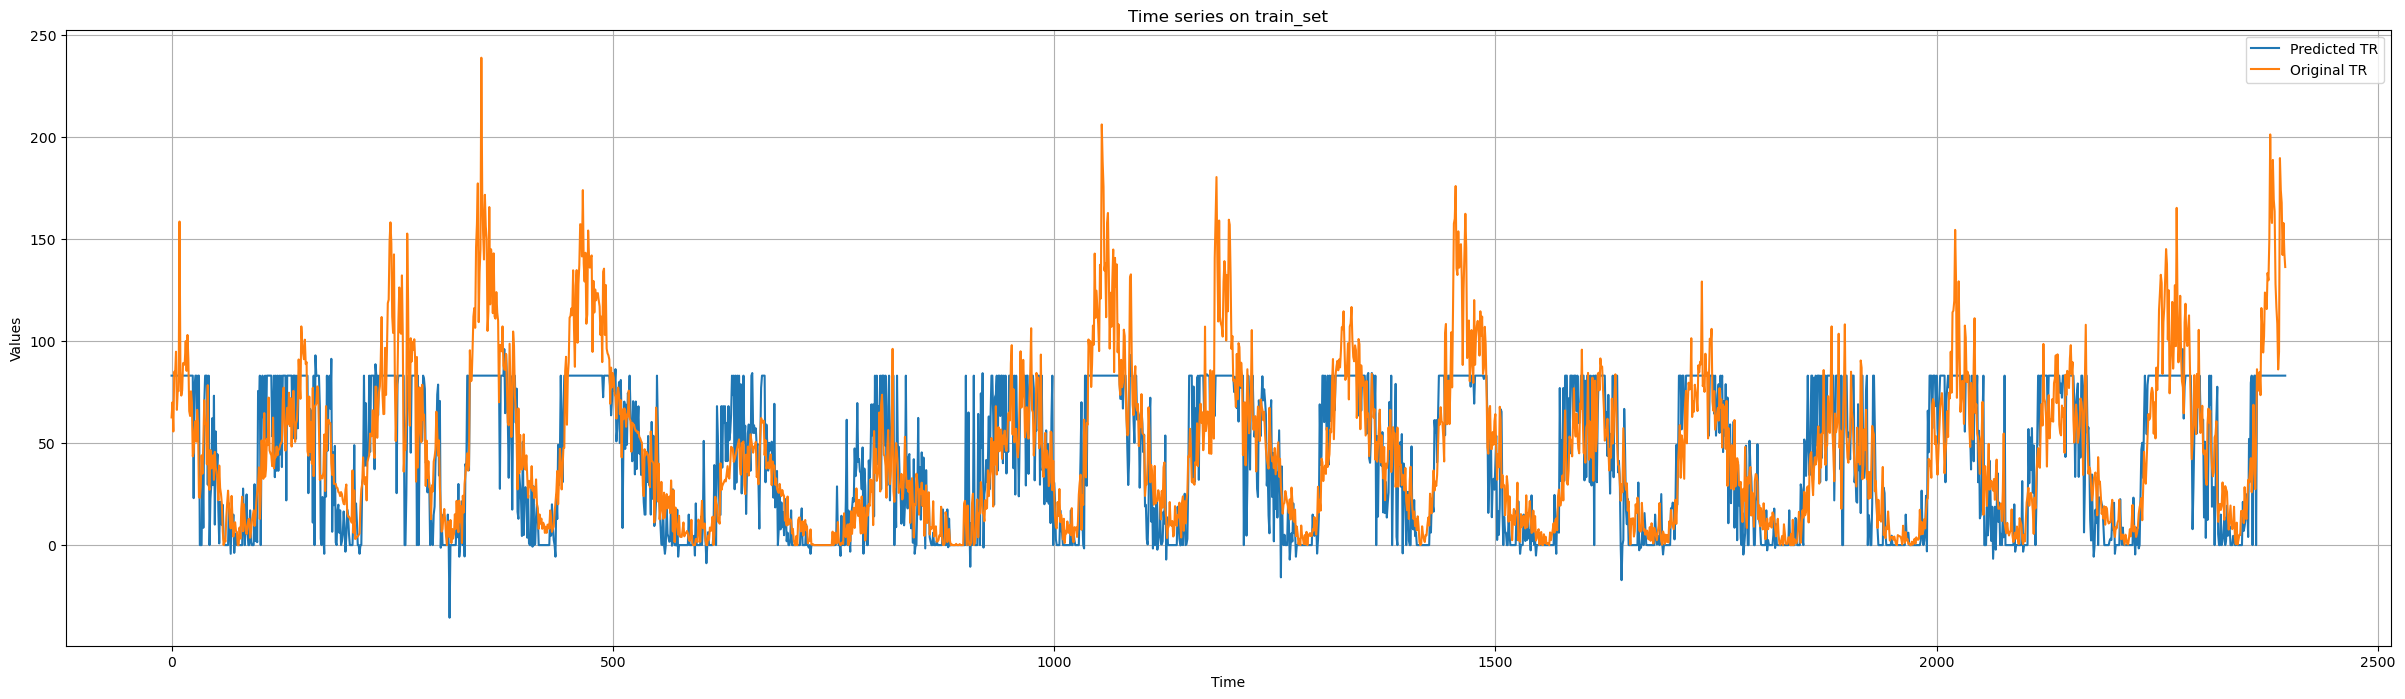

In [17]:
salve_plot(final_trainer, train_X, train_Y,"train_set")

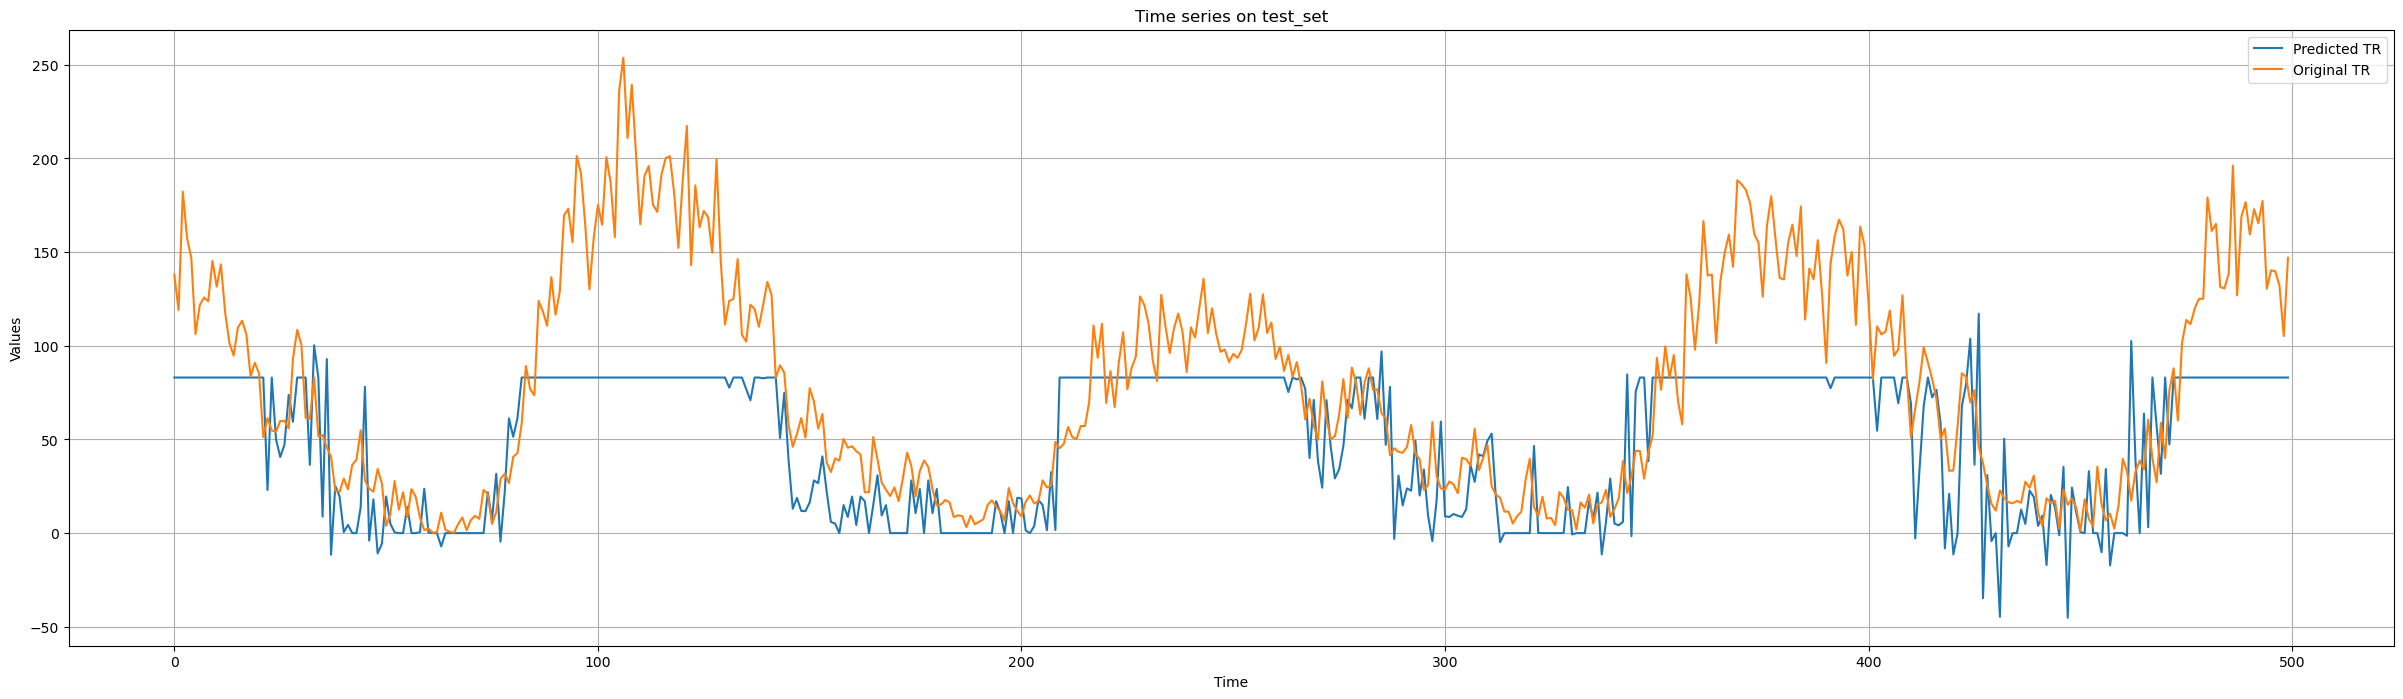

In [18]:
salve_plot(final_trainer, test_X, test_Y,"test_set")

In [15]:
with open("results.json","w") as f:
    json.dump({"Train Error":tr_loss, "Test Error":ts_loss}, f)